### WARRIOR POWER LATE AND DEFAULT DETECTION IN PYTHON

Worrior Power have experienced an increase in late and defaulted payment over the last twelve months. In this analysis, I applied  supervised learning algorithms to detect late and default behavior based upon past 12 months of customer data. This file provides codes,technical and theoretical insights.


1. Data Exploration 
2. Logistic Regression
3. Decision Tree Classifier
4. Results

### Imports

In [90]:
## Basic packages

import pandas as pd
import numpy as np
import copy
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# import sklearn packages
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from IPython.display import Markdown, display
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import resample

# Function that helps to print out model evoluation metrics
# name: get_results()
# arguments: 
            # clf: classifier
            # clf_name: classifier's name (e.g.: 'Decision Tree')

def get_results(clf,clf_name,X_train,y_train,X_test,y_test):
    y_pred = clf.predict(X_test)
    
    printmd('### Accuracy')
    print('Training Accuracy('+clf_name+'): {:2.2%}'.format(accuracy_score(y_train, clf.predict(X_train))))    
    print('Test Accuracy('+clf_name+'): {:2.2%}'.format(accuracy_score(y_test, clf.predict(X_test))))
    printmd('***')
    printmd('### Classification Report') 
    print(classification_report(y_test, y_pred))
    
    probs = clf.predict_proba(X_test) # Predict class probabilities of the input samples 
    preds = probs[:,1]
    fpr,tpr,threshold = roc_curve(y_test, preds) 
    roc_auc = auc(fpr,tpr)
    print('ROC AUC Score('+clf_name+'): {:2.2%}'.format(roc_auc))
    
    printmd('***')
    printmd('### Cross-Validation')
    cv_accuracy = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print('Accuracy: {:2.2%}'.format(np.mean(cv_accuracy)))
    cv_recall = cross_val_score(clf, X_train, y_train, cv=5, scoring='recall')
    print('Recall: {:2.2%}'.format(np.mean(cv_recall)))
    cv_precision = cross_val_score(clf, X_train, y_train, cv=5, scoring='precision')
    print('Precision: {:2.2%}'.format(np.mean(cv_precision)))
    cv_f1 = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
    print('F1-score: {:2.2%}'.format(np.mean(cv_f1)))
    cv_roc_auc = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')
    print('ROC AUC Score: {:2.2%}'.format(np.mean(cv_roc_auc)))
    printmd('***')
    
    printmd('### Confusion Matrix')

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot = True, fmt="d", linewidths=.5, square = True,cmap='Blues')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix ('+clf_name+')',fontsize=16)
    
    # calculate the Optimum Threshold
    for i in range(len(fpr)):
        if fpr[i] + tpr[i] >= 1:
            i = i -1
            break
    plt.show()
    
    printmd('***')
    
    printmd('### ROC Curve')
    plt.plot(fpr, tpr, lw=1,label='ROC Curve(area = %0.3f)    Optimum Threshold = %0.3f' % (roc_auc, threshold[i]))
    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve ('+clf_name+')',fontsize=16)
    plt.legend(loc="lower right")
    plt.show()
        
# name: printmd()
# function: print with markdown format.
def printmd(string):
    display(Markdown(string))

# name: var_dist()
# function: show single variable's distribution

def var_dist(dataframe,variable, *args, **kwargs):
    count = dataframe[variable].value_counts()
    count_df = pd.DataFrame({variable: count.index,'Count': count.values})
    print(count_df.to_string(index=False))
    # plot the distribution
    plt.figure(figsize=(8,4))
    sns.barplot(x = variable, y ="Count", data = count_df)
    # fetch optional argument varName
    varName = kwargs.get('varName', None)
    if varName != None:
        plt.title(varName + ' Distribution',fontsize=20)
    else:
        plt.title(variable + ' Distribution',fontsize=20)   
    plt.show()
    
    
    

### 1. WARRIOR CUSTOMER DATA EXPLORATION

In [91]:
c=pd.read_csv('CACI_InterviewAssessment_BillDefaults_Data.csv')

### 1.1. Explore the features available in your dataframe

In [70]:
c.head(9).T

,0,1,2,3,4,5,6,7,8
uid,1,2,3,4,5,6,7,8,9
late_default,1,0,0,0,0,0,0,1,0
cli_anc,3300,3010,2780,4400,4540,5100,1950,1850,4830
cli_ageband,2,4,6,3,4,5,5,4,7
cli_payment,P,D,D,D,D,C,C,C,C
oc_inc0010,0.0303546,0.313327,0.0636084,0.0132142,0.00727704,0.328021,0.0155901,0.01324,0.118313
oc_inc50pl,0.475623,0.06059,0.161459,0.469807,0.52797,0.0530113,0.55724,0.554054,0.116144
oc_children3pl,0.0213739,0.0279865,0.00191987,0.19521,0.180975,0.00442994,0.0241513,0.0677186,0.000224592
oc_children0004,0.165254,0.0243812,0.00307313,0.169214,0.218566,0.00629518,0.0116415,0.0308694,0.000561887
oc_children0510,0.132862,0.0665482,0.00503612,0.413697,0.414872,0.012161,0.0288538,0.116919,0.000964122


In [71]:
# check the number of elements per axis
# 19 features and 20.000 records
c.shape

(20000, 19)

In [72]:
# Check the data types and number of entries for each feature for the training and test sets. 
# There is no missing entries 

c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   uid              20000 non-null  int64  
 1   late_default     20000 non-null  int64  
 2   cli_anc          20000 non-null  int64  
 3   cli_ageband      20000 non-null  int64  
 4   cli_payment      20000 non-null  object 
 5   oc_inc0010       20000 non-null  float64
 6   oc_inc50pl       20000 non-null  float64
 7   oc_children3pl   20000 non-null  float64
 8   oc_children0004  20000 non-null  float64
 9   oc_children0510  20000 non-null  float64
 10  oc_retired       20000 non-null  float64
 11  oc_selfemp       20000 non-null  float64
 12  oc_student       20000 non-null  float64
 13  oc_unemp         20000 non-null  float64
 14  oc_socrent       20000 non-null  float64
 15  oc_privrent      20000 non-null  float64
 16  oc_overdraft     20000 non-null  float64
 17  oc_savs10pl 

In [73]:
# descriptive statistics for each paramaters
c.describe().T

,count,mean,std,min,25%,50%,75%,max
uid,20000.0,10000.500000,5773.647028,1.000000,5000.750000,10000.500000,15000.250000,20000.000000
late_default,20000.0,0.187250,0.390122,0.000000,0.000000,0.000000,0.000000,1.000000
cli_anc,20000.0,3529.824500,4058.201875,1500.000000,2490.000000,3490.000000,4490.000000,523450.000000
cli_ageband,20000.0,3.895050,1.745190,1.000000,2.000000,4.000000,5.000000,7.000000
oc_inc0010,20000.0,0.074449,0.075572,0.001618,0.023501,0.046928,0.096848,0.545317
oc_inc50pl,20000.0,0.300304,0.159374,0.001081,0.172284,0.299422,0.418561,0.798334
oc_children3pl,20000.0,0.064532,0.077166,0.000042,0.006586,0.038373,0.096738,0.653977
oc_children0004,20000.0,0.110644,0.125292,0.000154,0.008681,0.037014,0.204455,0.628564
oc_children0510,20000.0,0.148161,0.149527,0.000225,0.014808,0.094227,0.283517,0.616068
oc_retired,20000.0,0.193507,0.344225,0.000008,0.000054,0.000549,0.115121,0.965043


In [74]:
# Count the occurrences of late default and print them
occ = c['late_default'].value_counts()
occ

0    16255
1     3745
Name: late_default, dtype: int64

/Users/oyakesgin/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


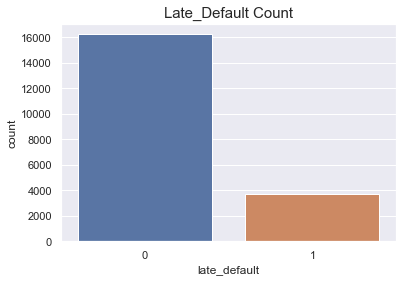

Ratio of late_default cases: 0.18725
Ratio of non-late_default cases: 0.81275


In [75]:
# Print the ratio of late_default cases
ratio_cases = occ/len(c.index)
sns.countplot(c.late_default)
plt.title('Late_Default Count',  fontsize = 15)
plt.show()
print(f'Ratio of late_default cases: {ratio_cases[1]}\nRatio of non-late_default cases: {ratio_cases[0]}')

The ratio of late_default payment is around 19%(I find it slightly high) 
This is a case of class imbalance problem.

### 1.2 Feature Engineering For Categorical Variable

Categorical data are variables that contain label values rather than numeric values. Many machine learning algorithms require all input variables and output variables to be numeric. Decision tree can be learned directly from categorical data with no data transform required (this depends on the specific implementation)


In [79]:
#Payment method of customer is the only categorical variable
cf_num = copy.deepcopy(c)
# get categorical columns
cf_cat = cf_num.select_dtypes(include=[object])
cf_cat.head()

,cli_payment
0,P
1,D
2,D
3,D
4,D


cli_payment  Count
          D   9418
          P   5580
          C   5002


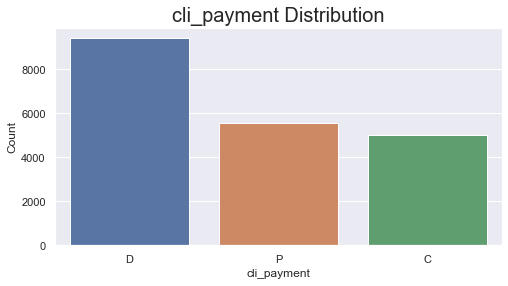

In [80]:
#Count the occurrences of Payment Methods and show their distribution
var_dist(cf_cat,'cli_payment')

D-Direct Debit is the highest numbers, C-Cash or Card is the lowest numbers in our data set

In [83]:
#Encoding Categorical Feature with Dummy Function
cf = pd.get_dummies(c)
cf.head()

,uid,late_default,cli_anc,cli_ageband,oc_inc0010,oc_inc50pl,oc_children3pl,oc_children0004,oc_children0510,oc_retired,...,oc_student,oc_unemp,oc_socrent,oc_privrent,oc_overdraft,oc_savs10pl,oc_cards2pl,cli_payment_C,cli_payment_D,cli_payment_P
0,1,1,3300,2,0.030355,0.475623,0.021374,0.165254,0.132862,0.000031,...,0.042310,0.025378,0.012832,0.793294,0.172783,0.179815,0.306499,0,0,1
1,2,0,3010,4,0.313327,0.060590,0.027987,0.024381,0.066548,0.001478,...,0.007655,0.075782,0.750370,0.069109,0.114262,0.036342,0.075723,0,1,0
2,3,0,2780,6,0.063608,0.161459,0.001920,0.003073,0.005036,0.817904,...,0.002262,0.000317,0.026640,0.021453,0.056320,0.304369,0.195838,0,1,0
3,4,0,4400,3,0.013214,0.469807,0.195210,0.169214,0.413697,0.000132,...,0.023778,0.029276,0.022806,0.120235,0.184631,0.147863,0.286992,0,1,0
4,5,0,4540,4,0.007277,0.527970,0.180975,0.218566,0.414872,0.001453,...,0.002274,0.031067,0.001271,0.082093,0.181568,0.203448,0.244626,0,1,0


### 1.3. Correlation Matrix

Correlation coefficients are used to measure how strong a relationship is between two variables. It is the covariance of two variables, divided by the product of their standard deviations. Covariance measures the total variation of two random variables from their expected values. The Standard Deviation is a measure of how spread out numbers are (the square root of Variance)

<AxesSubplot:>

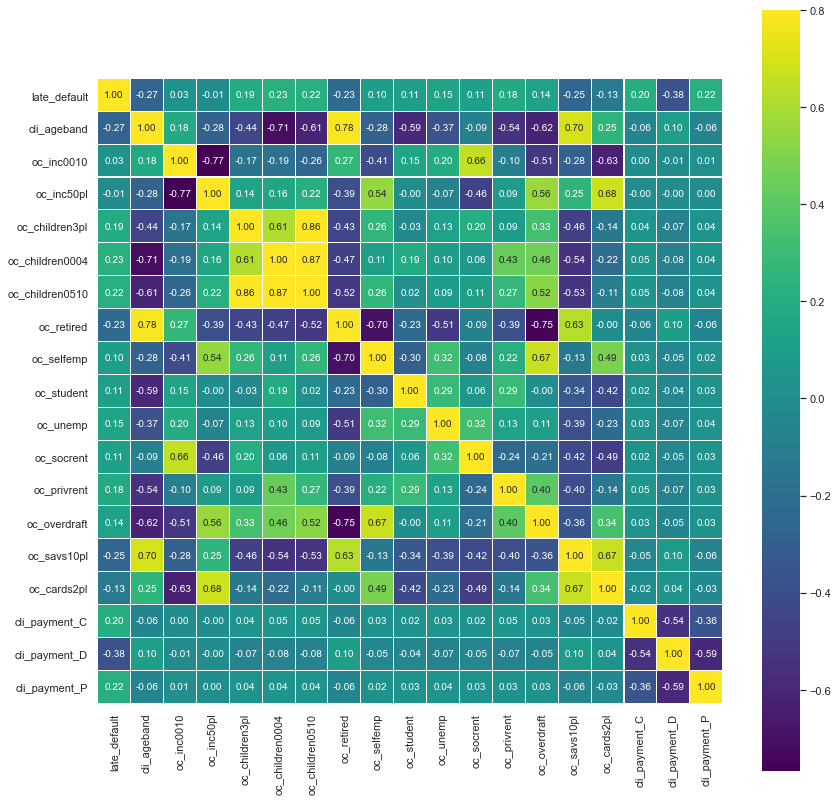

In [93]:
# I want to check out the correlations between the numeric features. I used a heatmap to do this.
# there are  low correlations between features and late_default.
cor = cf.corr()
colormap = plt.cm.viridis
cor = cor.drop(['uid','cli_anc'],axis=1).drop(['uid','cli_anc'],axis=0)
plt.figure(figsize=(14,14))
sns.heatmap(cor,vmax=0.8,cmap=colormap,annot=True,fmt='.2f',square=True,annot_kws={'size':10},linecolor='white',linewidths=0.1)

Variables;
Customers with children(3 or more) or customers have childred aged 0-4 and 5-10 at home, 
Customers who rented their house from local authority, 
Customers cash and prepayment meter have positive relation and with late_dafault payment. 
In contrast, Variables:
Customers retired
Customer age band, customers have direct debit or saving(10K) account has negative relation with late default payment.

### 2. LOGISTIC REGRESSION

In statistics, logistic regression is used to model the probability of a certain class or event. Logistic regression always lies between 0 and 1.                                                   

Let p the probability of Y(late_dafault)=1; p=P(Y=1). The relationship between these variables can be denotated as 
ln(p/(1−p))=b0+b1x1+b2x2+....bnxn                           
Here the term p/(1−p) is known as the odds and denotes the likelihood of the event taking place. Thus ln(p/(1−p)) is known as the log odds and is simply used to map the probability that lies between 0 and 1 to a range between (−∞,+∞).
    Log term can be removed by raising linear side as a power of e. The result turns out to be the equation of Sigmoid Function.                                               

### 2.1. Splitting the Data Set 80/20

In [13]:
X = cf.drop(['late_default','uid'], axis=1)  
y = cf['late_default']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

### 2.2. Class Weight Calculation

I would expect that the class-weighted version of logistic regression to perform better than the standard version of logistic regression without any class weighting.
The LogisticRegression provides the class_weight argument that can be specified as a model hyperparameter. The class_weight is a dictionary that defines each class label (e.g. 0 and 1) and the weighting to apply in the calculation of the negative log likelihood when fitting the model.


In [85]:
#weighting = n_samples / (n_classes * n_samples_with_class)
#Weight for late_default 0 calculation
print(20000/(2*16255))
#Weight for late_default calculation
print(20000/(2 *3745))

0.6151953245155337
2.67022696929239


In [112]:
# Define the Logistic Regression model with weights
# solver Algorithm to use in the optimization problem. 
# I used liblinear because ‘liblinear’ is a good choice for For small datasets,
log_model = LogisticRegression(class_weight={0:0.61, 1:2.67}, random_state=42, solver='liblinear')

log_model.fit(X_train,y_train)

LogisticRegression(class_weight={0: 0.61, 1: 2.67}, random_state=42,
                   solver='liblinear')

### Accuracy

Training Accuracy(Logistic Regression): 74.44%
Test Accuracy(Logistic Regression): 73.55%


***

### Classification Report

              precision    recall  f1-score   support

           0       0.96      0.70      0.81      3244
           1       0.41      0.87      0.55       756

    accuracy                           0.74      4000
   macro avg       0.68      0.79      0.68      4000
weighted avg       0.85      0.74      0.76      4000

ROC AUC Score(Logistic Regression): 83.55%


***

### Cross-Validation

Accuracy: 74.27%
Recall: 86.48%
Precision: 41.05%
F1-score: 55.68%
ROC AUC Score: 84.64%


***

### Confusion Matrix

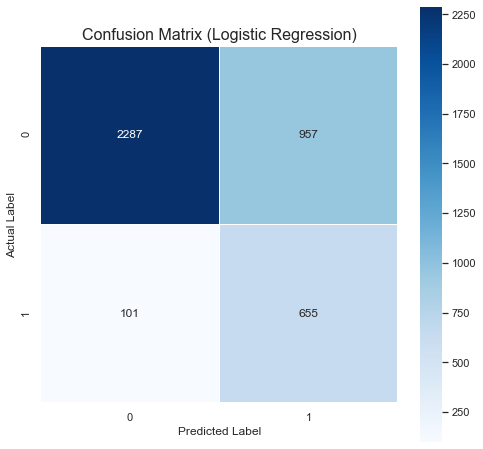

***

### ROC Curve

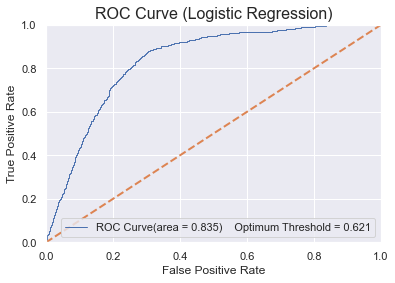

In [116]:
lr_result = get_results(c,'Logistic Regression',X_train,y_train,X_test,y_test)

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

### FINDINGS

The model predicts 756 cases of late_default, out of which 655 are actual late_deafult. I have only 101 false positives. This is really good, and as a result you have a very high recall score. You do however, miss 18 cases of actual fraud. Recall is therefore not as good as precision.


a credit card company might want to catch as much fraud as possible and reduce false negatives, as fraudulent transactions can be incredibly costly

### 2.3 Logistic Regression with Upsampling

Logistic Regression is one of the most used ML algorithms in binary classification

In [18]:
# set features & target
X1 = cf.drop(['late_default','uid'], axis=1)  
y1 = cf['late_default']
X1.head()


,cli_anc,cli_ageband,oc_inc0010,oc_inc50pl,oc_children3pl,oc_children0004,oc_children0510,oc_retired,oc_selfemp,oc_student,oc_unemp,oc_socrent,oc_privrent,oc_overdraft,oc_savs10pl,oc_cards2pl,cli_payment_C,cli_payment_D,cli_payment_P
0,3300,2,0.030355,0.475623,0.021374,0.165254,0.132862,0.000031,0.150273,0.042310,0.025378,0.012832,0.793294,0.172783,0.179815,0.306499,0,0,1
1,3010,4,0.313327,0.060590,0.027987,0.024381,0.066548,0.001478,0.118803,0.007655,0.075782,0.750370,0.069109,0.114262,0.036342,0.075723,0,1,0
2,2780,6,0.063608,0.161459,0.001920,0.003073,0.005036,0.817904,0.021434,0.002262,0.000317,0.026640,0.021453,0.056320,0.304369,0.195838,0,1,0
3,4400,3,0.013214,0.469807,0.195210,0.169214,0.413697,0.000132,0.101393,0.023778,0.029276,0.022806,0.120235,0.184631,0.147863,0.286992,0,1,0
4,4540,4,0.007277,0.527970,0.180975,0.218566,0.414872,0.001453,0.119810,0.002274,0.031067,0.001271,0.082093,0.181568,0.203448,0.244626,0,1,0


In [19]:
# split into training & test set (80%/20%)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)


### Upsampling

Upsampling is a technique used to match the number of minority class to the majority class.

The key of upsampling is to only upsample the training set but not the test set.

In [20]:
# concatenate training data
lr1_train = pd.concat([X1_train, y1_train], axis=1)

In [21]:
# separate late_default0 & late_default1
lr_late_default0 = lr1_train[lr1_train['late_default']==0]
lr_late_default1= lr1_train[lr1_train['late_default']==1]


In [22]:
lr_late_default0.shape


(12994, 20)

In [23]:
lr_late_default1.shape

(3006, 20)

In [24]:
# upsample late_default1
late_default1_resampled = resample(lr_late_default1,
                            replace=True,
                            n_samples=len(lr_late_default0),
                            random_state=42)

In [25]:
# combine late_default0 and upsampled late_default1_resampled
lr_train_up = pd.concat([lr_late_default0, late_default1_resampled])


 late_default  Count
            1  12994
            0  12994


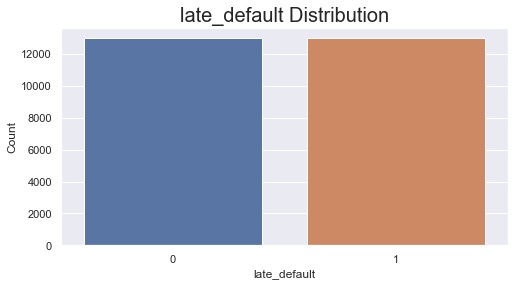

In [26]:
var_dist(lr_train_up,'late_default')

In [27]:
y_train_up = lr_train_up['late_default']
X_train_up = lr_train_up.drop('late_default', axis=1)

In [28]:
# Define the Logistic Regression model with weights
log_model_resampled = LogisticRegression(class_weight='balanced', random_state=5, solver='liblinear')

log_model_resampled.fit(X_train_up,y_train_up)

LogisticRegression(class_weight='balanced', random_state=5, solver='liblinear')

### Accuracy

Training Accuracy(Logistic Regression - Upsampled): 78.73%
Test Accuracy(Logistic Regression - Upsampled): 73.92%


***

### Classification Report

              precision    recall  f1-score   support

           0       0.96      0.71      0.82      3261
           1       0.41      0.88      0.56       739

    accuracy                           0.74      4000
   macro avg       0.68      0.79      0.69      4000
weighted avg       0.86      0.74      0.77      4000

ROC AUC Score(Logistic Regression - Upsampled): 84.58%


***

### Cross-Validation

/Users/oyakesgin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy: 78.71%


/Users/oyakesgin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Recall: 86.15%


/Users/oyakesgin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Precision: 75.00%


/Users/oyakesgin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


F1-score: 80.19%
ROC AUC Score: 84.29%


/Users/oyakesgin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


***

### Confusion Matrix

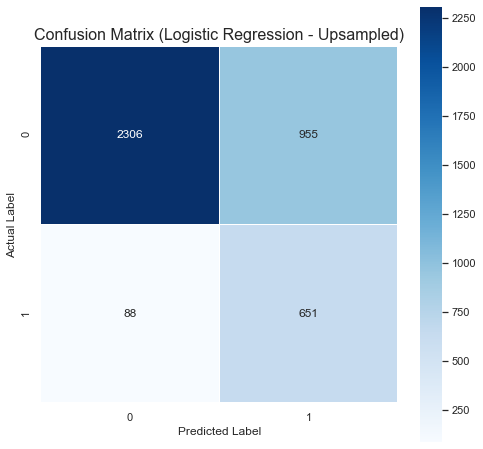

***

### ROC Curve

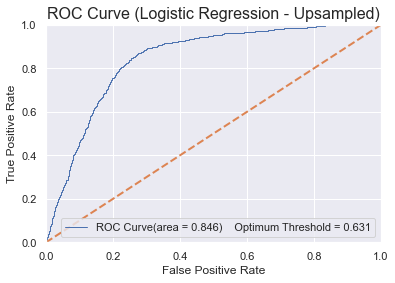

In [29]:
lgupsampling_result = get_results(log_model_resampled,'Logistic Regression - Upsampled',X_train_up,y_train_up,X1_test,y1_test)

Credit card company wants to optimize for recall rate.
Precision: Fraction of actual late_default cases out of all predicted late_default case
Recall: Fraction of predicted late_default cases out of all actual late_default case 

### 2.1. DECISION TREE WITH UPSAMPLING

Commonly used for late_default detection
Transparent results, easily interpreted by analysts
Decision trees are prone to overfit the data

In [30]:
# set features & target
cf_up = copy.deepcopy(cf)
y_up = cf_up['late_default']
X_up = cf_up.drop('late_default', axis=1)
X_up.head()

,uid,cli_anc,cli_ageband,oc_inc0010,oc_inc50pl,oc_children3pl,oc_children0004,oc_children0510,oc_retired,oc_selfemp,oc_student,oc_unemp,oc_socrent,oc_privrent,oc_overdraft,oc_savs10pl,oc_cards2pl,cli_payment_C,cli_payment_D,cli_payment_P
0,1,3300,2,0.030355,0.475623,0.021374,0.165254,0.132862,0.000031,0.150273,0.042310,0.025378,0.012832,0.793294,0.172783,0.179815,0.306499,0,0,1
1,2,3010,4,0.313327,0.060590,0.027987,0.024381,0.066548,0.001478,0.118803,0.007655,0.075782,0.750370,0.069109,0.114262,0.036342,0.075723,0,1,0
2,3,2780,6,0.063608,0.161459,0.001920,0.003073,0.005036,0.817904,0.021434,0.002262,0.000317,0.026640,0.021453,0.056320,0.304369,0.195838,0,1,0
3,4,4400,3,0.013214,0.469807,0.195210,0.169214,0.413697,0.000132,0.101393,0.023778,0.029276,0.022806,0.120235,0.184631,0.147863,0.286992,0,1,0
4,5,4540,4,0.007277,0.527970,0.180975,0.218566,0.414872,0.001453,0.119810,0.002274,0.031067,0.001271,0.082093,0.181568,0.203448,0.244626,0,1,0


In [31]:
# split into training & test set (80%/20%)
X2_train, X2_test, y2_train, y2_test = train_test_split(X_up, y_up, test_size=0.2, random_state=42)

In [32]:
# concatenate training data
dt_train = pd.concat([X2_train, y2_train], axis=1)

In [33]:
# separate late_default0 & late_default1
late_default0 = dt_train[dt_train['late_default']==0]
late_default1 = dt_train[dt_train['late_default']==1]

In [34]:
# upsample late_default1
late_default2_resampled = resample(late_default1,
                            replace=True,
                            n_samples=len(late_default0),
                            random_state=42)

In [35]:
# combine churn0 and upsampled churn1_resampled
dt_train_up = pd.concat([late_default0, late_default2_resampled])

 late_default  Count
            1  12994
            0  12994


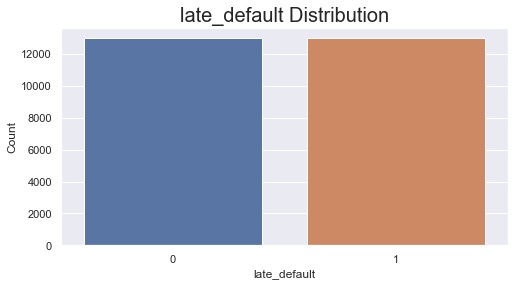

In [36]:
# check
var_dist(dt_train_up,'late_default')

In [37]:
features_name = list(X_up.columns.values)
target_name = ['late_default','no_late_default']
features_name,target_name

(['uid',
  'cli_anc',
  'cli_ageband',
  'oc_inc0010',
  'oc_inc50pl',
  'oc_children3pl',
  'oc_children0004',
  'oc_children0510',
  'oc_retired',
  'oc_selfemp',
  'oc_student',
  'oc_unemp',
  'oc_socrent',
  'oc_privrent',
  'oc_overdraft',
  'oc_savs10pl',
  'oc_cards2pl',
  'cli_payment_C',
  'cli_payment_D',
  'cli_payment_P'],
 ['late_default', 'no_late_default'])

In [38]:
y2_train = dt_train_up['late_default']
X2_train = dt_train_up.drop('late_default', axis=1)

In [39]:
clf_dt = DecisionTreeClassifier(random_state = 42,
                                 max_depth=10, 
                                 max_features=20, 
                                 max_leaf_nodes=30,
                                 min_samples_leaf=5,
                                 min_samples_split=7
                                ) # accuracy

clf_dt.fit(X2_train, y2_train)

DecisionTreeClassifier(max_depth=10, max_features=20, max_leaf_nodes=30,
                       min_samples_leaf=5, min_samples_split=7,
                       random_state=42)

### Accuracy

Training Accuracy(Decision Tree - Upsampled): 79.91%
Test Accuracy(Decision Tree - Upsampled): 73.58%


***

### Classification Report

              precision    recall  f1-score   support

           0       0.96      0.71      0.81      3261
           1       0.40      0.86      0.54       739

    accuracy                           0.74      4000
   macro avg       0.68      0.78      0.68      4000
weighted avg       0.85      0.74      0.76      4000

ROC AUC Score(Decision Tree - Upsampled): 83.14%


***

### Cross-Validation

Accuracy: 79.02%
Recall: 86.73%
Precision: 75.18%
F1-score: 80.52%
ROC AUC Score: 84.44%


***

### Confusion Matrix

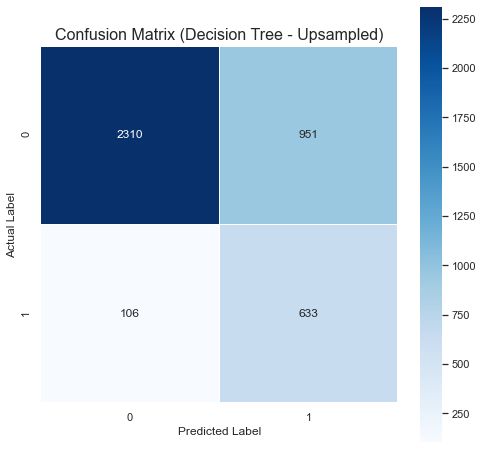

***

### ROC Curve

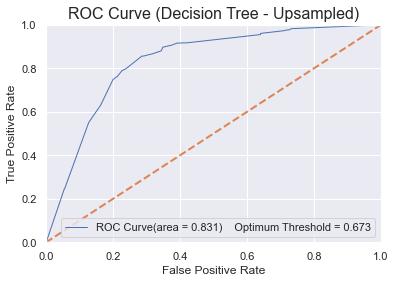

In [40]:
dt_result = get_results(clf_dt,'Decision Tree - Upsampled',X2_train,y2_train,X2_test,y2_test)

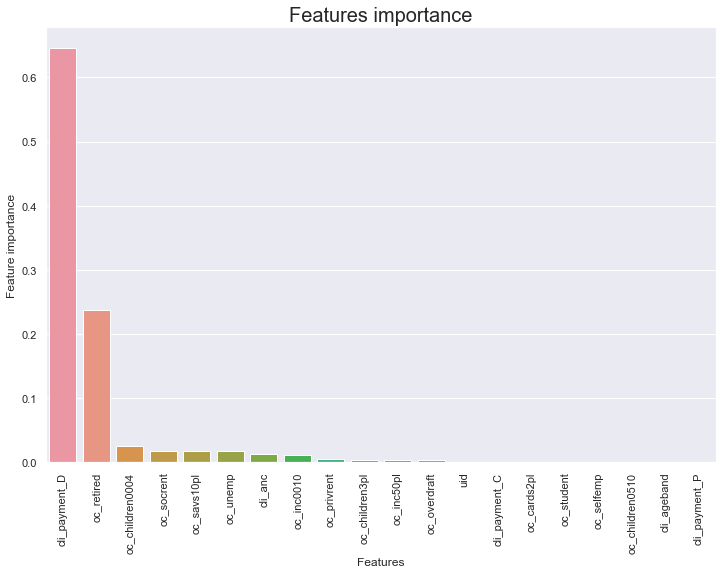

In [41]:
tmp = pd.DataFrame({'Features': features_name, 'Feature importance': clf_dt.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (12,8))
plt.title('Features importance',fontsize=20)
s = sns.barplot(x='Features',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

### 2.2. Decision Tree (imbalanced data)

In [42]:
# set features & target

y3 = cf['late_default']
X3 = cf.drop('late_default', axis=1)
X3.head()

,uid,cli_anc,cli_ageband,oc_inc0010,oc_inc50pl,oc_children3pl,oc_children0004,oc_children0510,oc_retired,oc_selfemp,oc_student,oc_unemp,oc_socrent,oc_privrent,oc_overdraft,oc_savs10pl,oc_cards2pl,cli_payment_C,cli_payment_D,cli_payment_P
0,1,3300,2,0.030355,0.475623,0.021374,0.165254,0.132862,0.000031,0.150273,0.042310,0.025378,0.012832,0.793294,0.172783,0.179815,0.306499,0,0,1
1,2,3010,4,0.313327,0.060590,0.027987,0.024381,0.066548,0.001478,0.118803,0.007655,0.075782,0.750370,0.069109,0.114262,0.036342,0.075723,0,1,0
2,3,2780,6,0.063608,0.161459,0.001920,0.003073,0.005036,0.817904,0.021434,0.002262,0.000317,0.026640,0.021453,0.056320,0.304369,0.195838,0,1,0
3,4,4400,3,0.013214,0.469807,0.195210,0.169214,0.413697,0.000132,0.101393,0.023778,0.029276,0.022806,0.120235,0.184631,0.147863,0.286992,0,1,0
4,5,4540,4,0.007277,0.527970,0.180975,0.218566,0.414872,0.001453,0.119810,0.002274,0.031067,0.001271,0.082093,0.181568,0.203448,0.244626,0,1,0


In [43]:
# split into training & test set (80%/20%)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

In [47]:
c_dt2 = DecisionTreeClassifier(random_state = 42,
                                 max_depth=10, 
                                 max_features=20, 
                                 max_leaf_nodes=30,
                                 min_samples_leaf=5,
                                 min_samples_split=7,
                                 class_weight={0:0.61, 1:2.67}
                                ) # accuracy

c_dt2.fit(X3_train, y3_train)

DecisionTreeClassifier(class_weight={0: 0.61, 1: 2.67}, max_depth=10,
                       max_features=20, max_leaf_nodes=30, min_samples_leaf=5,
                       min_samples_split=7, random_state=42)

### Accuracy

Training Accuracy(Decision Tree2): 75.08%
Test Accuracy(Decision Tree2): 74.20%


***

### Classification Report

              precision    recall  f1-score   support

           0       0.96      0.72      0.82      3261
           1       0.41      0.86      0.55       739

    accuracy                           0.74      4000
   macro avg       0.68      0.79      0.69      4000
weighted avg       0.86      0.74      0.77      4000

ROC AUC Score(Decision Tree2): 83.48%


***

### Cross-Validation

Accuracy: 73.52%
Recall: 85.20%
Precision: 40.33%
F1-score: 54.73%
ROC AUC Score: 83.09%


***

### Confusion Matrix

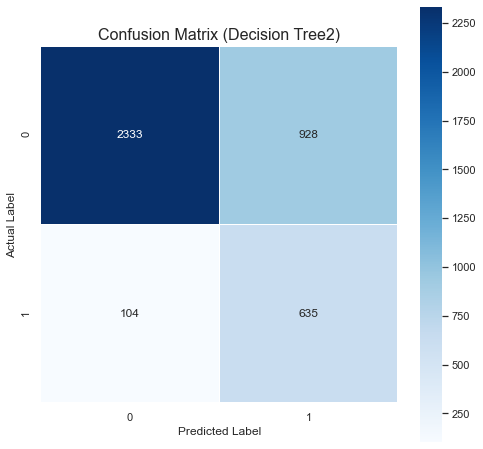

***

### ROC Curve

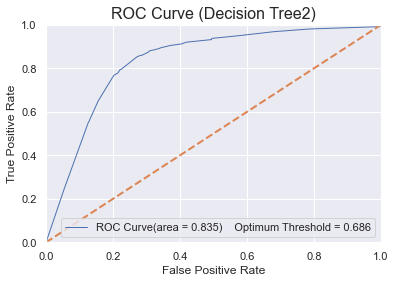

In [117]:
c_dt2_results = get_results(c_dt2,'Decision Tree2',X3_train,y3_train,X3_test,y3_test)

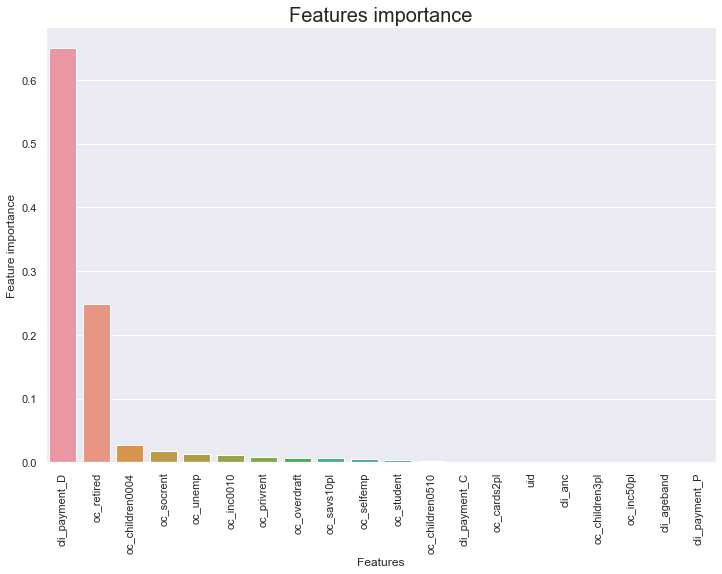

In [118]:
tmp = pd.DataFrame({'Features': features_name, 'Feature importance': c_dt2.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (12,8))
plt.title('Features importance',fontsize=20)
s = sns.barplot(x='Features',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

### 2.3.Random Forest Classifier

In [52]:
y4 = cf['late_default']
X4 = cf.drop('late_default', axis=1)
X4.head()

# split into training & test set (80%/20%)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42)

rf_clf2 = RandomForestClassifier() 
rf_clf2.fit(X4_train, y4_train)

RandomForestClassifier()

In [53]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gin i', 
max_depth=12, max_features='auto', max_leaf_nodes=None,
min_impurity_decrease=0.0, min_impurity_split=None, 
min_samples_leaf=1, min_samples_split=2,
min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=1,
oob_score=False, random_state=None, verbose=0,
warm_start=False)

RandomForestClassifier(criterion='gin i', max_depth=12, n_estimators=1,
                       n_jobs=1)

In [54]:
print("Binary Random Forest Accuracy:", accuracy_score(y3_test, rf_clf2.predict(X3_test ))) 

Binary Random Forest Accuracy: 0.82625


In [55]:
# Cross Validation 22 
cv_clf = rf_clf2 
cv_X_test = X4_test
cv_y_test = y4_test 
cv_folds = 5 
cv_scoring = 'roc_auc'
cv_result22 = cross_val_score(cv_clf,cv_X_test,cv_y_test,cv=cv_folds,scoring=cv_scoring 
) 

print('Mean: %.5f +/- %.5f' % (np.mean(cv_result22),np.std(cv_result22)))

Mean: 0.83185 +/- 0.01208


### Accuracy

Training Accuracy(Random Forest Classifier): 100.00%
Test Accuracy(Random Forest Classifier): 82.62%


***

### Classification Report

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      3261
           1       0.55      0.32      0.41       739

    accuracy                           0.83      4000
   macro avg       0.71      0.63      0.65      4000
weighted avg       0.80      0.83      0.81      4000

ROC AUC Score(Random Forest Classifier): 84.33%


***

### Cross-Validation

Accuracy: 82.19%
Recall: 31.40%
Precision: 54.62%
F1-score: 40.59%
ROC AUC Score: 83.63%


***

### Confusion Matrix

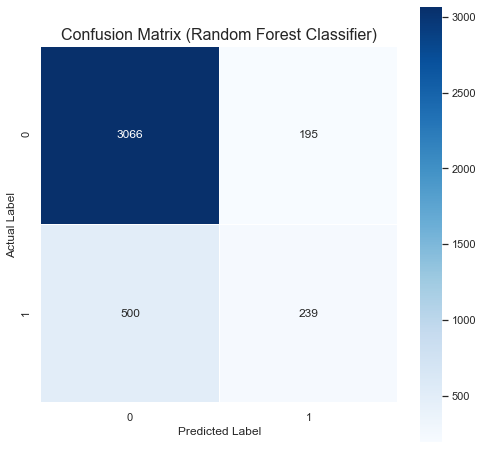

***

### ROC Curve

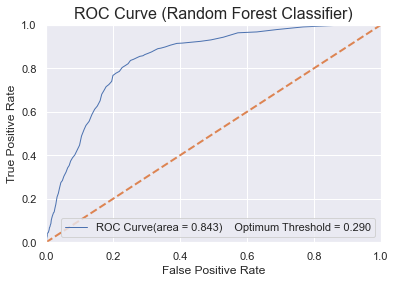

In [56]:
rf_clf2_results = get_results(rf_clf2,'Random Forest Classifier',X4_train,y4_train,X4_test,y4_test)

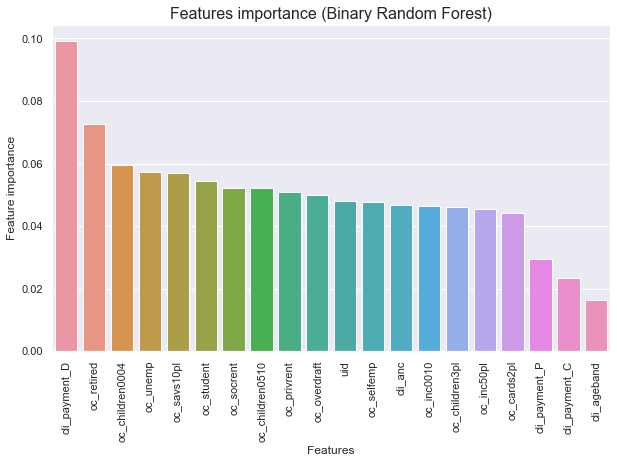

In [57]:
#calculation of importance of features 
tmp = pd.DataFrame({'Features': features_name, 'Feature importance': rf_clf2.feature_importances_}) 
tmp = tmp.sort_values(by='Feature importance',ascending=False) 
plt.figure(figsize = (10,6)) 
plt.title('Features importance (Binary Random Forest)',fontsize=16) 
s = sns.barplot(x='Features',y='Feature importance',data=tmp) 
s.set_xticklabels(s.get_xticklabels(),rotation=90) 
plt.show() 

In [154]:
### Hyperparameter tuning

In [270]:
# Grid Search
from sklearn.model_selection import GridSearchCV
#Define the parameter sets to test

model = RandomForestClassifier(n_estimators=10, 
                               criterion= 'gini', 
                               max_depth=None, 
                               min_samples_split=2, 
                               min_samples_leaf=1, 
                               max_features='auto', 
                               n_jobs=-1, class_weight=None)

param_grid = {'n_estimators': [1, 30],
              'max_features': ['auto', 'log2'], 
              'max_depth': [4, 8, 10, 12],
              'criterion': ['gini', 'entropy']}



# Combine the parameter sets with the defined model
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit the model to our training data and obtain best parameters

CV_model.fit(X3_train, y3_train)
CV_model.best_params_

{'criterion': 'gini',
 'max_depth': 12,
 'max_features': 'auto',
 'n_estimators': 1}